In [1]:
import numpy as np
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def normalize(v_):
    return v_ / np.linalg.norm(v_)

def rotate(v_, k_, theta):
    k_ = normalize(k_)
    term1 = v_ * np.cos(theta)
    term2 = np.cross(k_,v_) * np.sin(theta)
    term3 = k_ * np.dot(k_,v_) * (1.0 - np.cos(theta))
    return term1 + term2 + term3

def eff_angle(nu, mu):
    vec_ = rotate(rotate(np.array([0,0,1]), np.array([0,1,0]), nu), np.array([1,0,0]), mu)
    return np.arccos(np.dot(vec_, np.array([0,0,1])))

In [3]:
class Target:    
    def __init__(self, r_, v_):
        self.r_ = np.array(r_)
        self.v_ = np.array(v_)
        self.r_list_ = []
        return

In [4]:
class Missile:
    m_i = 1000.0 # kg
    m_f = 800.0 # kg
    length = 3.0 # m
    radius = 0.2 # m
    burn_time = 12.0 # s
    thrust = 1.0e6 # N
    max_thrust_angle = np.deg2rad(5.0) # rad
    guidance_delay = 5.0 # s
    
    def __init__(self, d_, K_p, K_d):
        self.r_ = np.zeros(3)
        self.v_ = np.zeros(3)
        self.d_ = d_
        self.p_ = rotate(self.d_, np.cross(self.d_,[0,0,1]), np.pi/2.0)
        self.omega_ = np.zeros(3)
        self.K_p = K_p
        self.K_d = K_d
        
        self.r_list_ = []
        self.v_list_ = []
        self.d_list_ = []
        self.p_list_ = []
        self.omega_list_ = []
        self.phi_list = []
        self.psi_list = []
        self.nu_list = []
        self.mu_list = []
        self.gamma_list = []
        self.e_list_ = []
        return
        
    def get_m(self, t):
        return self.m_i - (t/self.burn_time)*(self.m_i - self.m_f)
    
    def get_I__(self, t):
        m = self.get_m(t)
        I__ = np.array([[(1.0/12.0)*m*(3.0*self.radius**2 + self.length**2), 0.0, 0.0],
                        [0.0, (1.0/12.0)*m*(3.0*self.radius**2 + self.length**2), 0.0],
                        [0.0, 0.0, 0.5*m*self.radius**2]])
        
        q_ = np.cross(self.d_,self.p_)
        R__ = np.outer(self.p_,[1,0,0]) + np.outer(q_,[0,1,0]) + np.outer(self.d_,[0,0,1])
        I__ = np.matmul( np.matmul(R__,I__), R__.T )
        return I__
        
    def get_T_(self, t):
        if t < self.burn_time:
            return self.thrust
        else:
            return 0.0

In [5]:
class Simulation:
    def __init__(self, dt, K_p, K_d):
        self.dt = dt
        self.t = 0.0 # s
        self.t_list = []
        self.target = Target([0.0,100000.0,20000.0], [1000.0,0.0,0.0])
        self.missile = Missile(normalize(self.target.r_), K_p, K_d)
        
    def advance_simulation(self):        
        # Assemble right pointing vector
        q_ = np.cross(self.missile.d_,self.missile.p_)
        
        # Update target position
        self.target.r_ += self.target.v_*self.dt
        self.target.r_list_.append(np.copy(self.target.r_))
        
       # Calculate error vector
        e_ = self.target.r_ - self.missile.r_
        
        if self.t > self.missile.guidance_delay:
            prev_e_ = np.array([0,0,0])
            
            # e_ will converge to the vector pointing to the eventual collision location
            while np.linalg.norm(e_) - np.linalg.norm(prev_e_) > 1.0:
                prev_e_ = e_
                ete_impact = np.linalg.norm(e_) / np.dot(self.missile.v_, normalize(e_))
                target_r_impact_ = self.target.r_ + self.target.v_ * ete_impact                
                e_ = target_r_impact_ - self.missile.r_
                
            # Offset the velocity perpendicular to e_ to prevent drifting
            dir_ = normalize(e_)
            perp_v_ = self.missile.v_ - np.dot(self.missile.v_, dir_) * dir_
            e_ = e_ - perp_v_ * np.linalg.norm(e_) / np.linalg.norm(self.missile.v_)
        
        # Save error vector
        self.missile.e_list_.append(np.copy(e_))
        
        # Project error vector onto control planes
        e_phi_ = normalize(e_ - np.dot(e_,q_))
        e_psi_ = normalize(e_ - np.dot(e_,self.missile.p_))
        
        # Calculate error angles
        if abs( np.dot(e_phi_,self.missile.d_) ) > 1.0:
            phi = 0.0
        else:
            if np.dot( e_phi_,self.missile.p_ ) >= 0.0:
                phi = np.arccos( np.dot(e_phi_,self.missile.d_) )
            else:
                phi = -np.arccos( np.dot(e_phi_,self.missile.d_) )

        if not abs( np.dot(e_psi_,self.missile.d_) ) < 1.0:
            psi = 0.0
        else:
            if np.dot( e_psi_,q_ ) >= 0.0:
                psi = np.arccos( np.dot(e_psi_,self.missile.d_) )
            else:
                psi = -np.arccos( np.dot(e_psi_,self.missile.d_) )
        
        # Save error angles
        self.missile.phi_list.append(phi)
        self.missile.psi_list.append(psi)
        
        # Compute control from errors
        if self.t > self.missile.guidance_delay:
            dphi_dt = (phi - self.missile.phi_list[-2]) / self.dt
            dpsi_dt = (psi - self.missile.psi_list[-2]) / self.dt
            nu = self.missile.K_p * phi + self.missile.K_d * dphi_dt
            mu = self.missile.K_p * psi + self.missile.K_d * dpsi_dt
            gamma = eff_angle(nu, mu)
            if gamma / self.missile.max_thrust_angle > 1.0:
                nu = nu / (gamma / self.missile.max_thrust_angle)
                mu = mu / (gamma / self.missile.max_thrust_angle)
                gamma = eff_angle(nu, mu)
        else:
            nu = 0.0
            mu = 0.0
            gamma = 0.0
        
        # Save control signal
        self.missile.nu_list.append(nu)
        self.missile.mu_list.append(mu)
        self.missile.gamma_list.append(gamma)
        
        # Compute thrust vector from control deflections
        T_mag = self.missile.get_T_(self.t)
        T_dir_ = rotate(rotate(self.missile.d_, q_, -nu), self.missile.p_, mu)
        T_ = T_mag * T_dir_
         
        # Compute torque from thrust vector
        tau_ = np.cross( -self.missile.d_*(self.missile.length/2.0), T_ )
        
        # Compute rotation of missile
        if not np.linalg.norm(tau_) == 0.0:
            I__ = self.missile.get_I__(self.t)
            L_ = np.matmul(I__,self.missile.omega_)
            L_ += tau_*self.dt

            self.missile.omega_ = np.matmul( np.linalg.inv(I__), L_)

            if not self.missile.omega_list_:
                rot_ = self.missile.omega_*self.dt
            else:
                rot_ = 0.5*(self.missile.omega_list_[-1] + self.missile.omega_)*self.dt
                
            self.missile.d_ = rotate(self.missile.d_, rot_, np.linalg.norm(rot_))
            self.missile.p_ = rotate(self.missile.p_, rot_, np.linalg.norm(rot_))
        
        # Save missile orientation vectors
        self.missile.omega_list_.append(np.copy(self.missile.omega_))
        self.missile.d_list_.append(np.copy(self.missile.d_))
        self.missile.p_list_.append(np.copy(self.missile.p_))
        
        # Update missile velocity
        self.missile.v_ += ( (T_ / self.missile.get_m(self.t)) + [0.0, 0.0, -9.8] ) * self.dt
        
        # Compute missile movement
        if not self.missile.v_list_:
            self.missile.r_ += self.missile.v_*self.dt
        else:
            self.missile.r_ += 0.5*(self.missile.v_list_[-1] + self.missile.v_)*self.dt
        
        # Save missile velocity and position
        self.missile.v_list_.append(np.copy(self.missile.v_))
        self.missile.r_list_.append(np.copy(self.missile.r_))
        
        # Save timestamp and update simulation time
        self.t_list.append(self.t)
        self.t += self.dt
        
        return np.linalg.norm( self.missile.r_ - self.target.r_ )
    
    def run_simulation(self, max_time, max_iter):
        print('running simulation...')
        n = 0
        while True:
            n += 1
            dist = self.advance_simulation()
            if self.t > max_time:
                print('max time reached')
                break
            if dist < 10.0:
                print('target destroyed')
                break
            if n > max_iter:
                print('max iterations reached')
                break
            if simulation.missile.r_[2] < 0.0:
                print('missile crashed')
                break
            if simulation.missile.r_[2] > 1.1*simulation.target.r_[2]:
                print('missile overshot target')
                break
        print('done')
        return

In [6]:
simulation = Simulation(0.005,1.0,0.1)
simulation.run_simulation(75.0, 100000)

running simulation...
missile overshot target
done


In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()

nu_list = np.rad2deg(simulation.missile.nu_list)
mu_list = np.rad2deg(simulation.missile.mu_list)
phi_list = np.rad2deg(simulation.missile.phi_list)
psi_list = np.rad2deg(simulation.missile.psi_list)
gamma_list = np.rad2deg(simulation.missile.gamma_list)

v_list = []
for v_ in simulation.missile.v_list_:
    v_list.append(np.linalg.norm(v_))

#ax.plot(simulation.t_list, v_list)
    
#ax.plot(simulation.t_list, nu_list, label='nu')
#ax.plot(simulation.t_list, mu_list, label='mu')
ax.plot(simulation.t_list, gamma_list, label='gamma')
#ax.plot(simulation.t_list, phi_list, label='phi')
#ax.plot(simulation.t_list, psi_list, label='psi')

ax.legend()

<IPython.core.display.Javascript object>


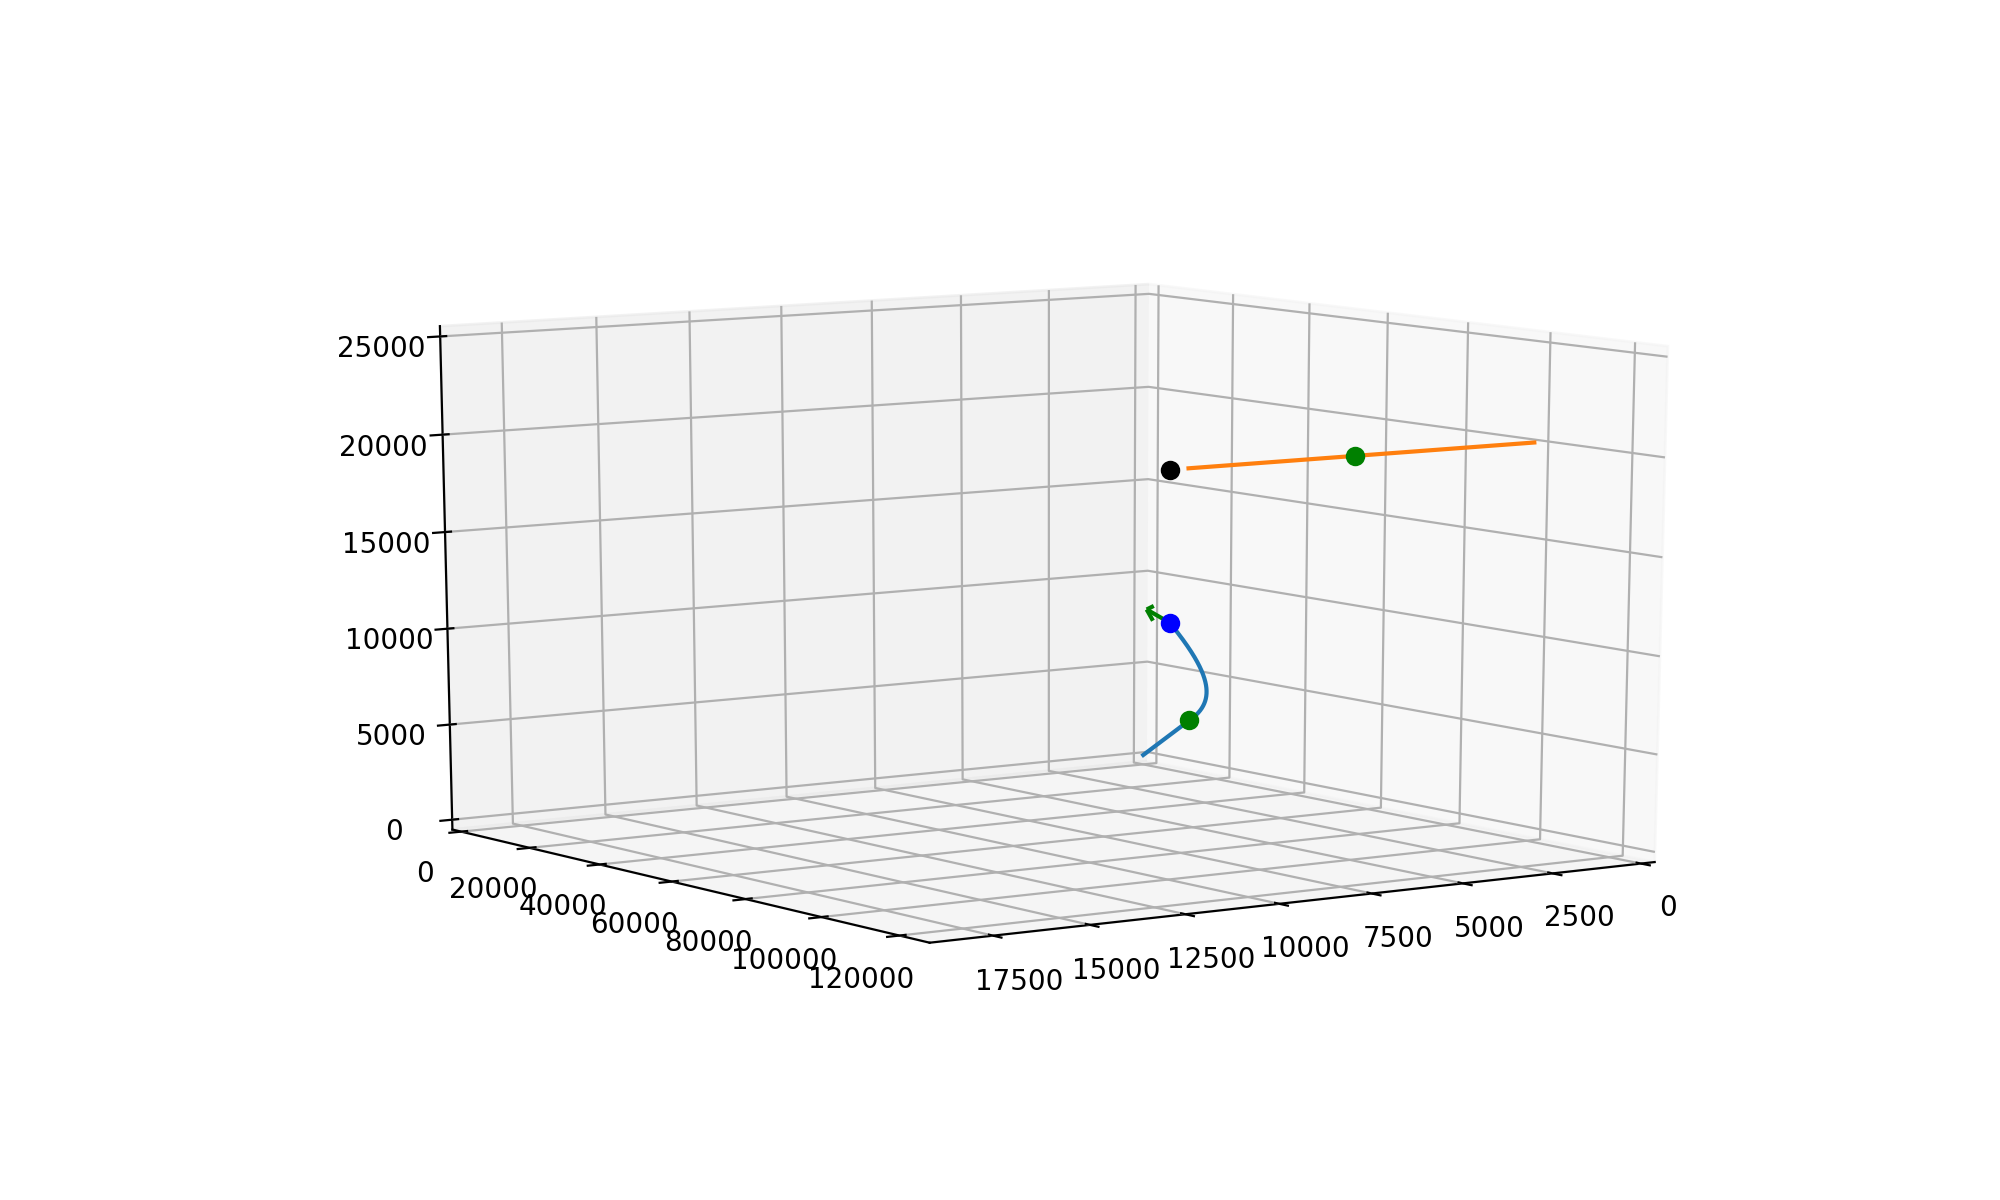

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

rm_ = np.array(simulation.missile.r_list_)
dm_ = np.array(simulation.missile.d_list_)
pm_ = np.array(simulation.missile.p_list_)
em_ = np.array(simulation.missile.e_list_)
rt_ = np.array(simulation.target.r_list_)

fac=25

xmin = None
xmax = None
ymin = None
ymax = None
zmin = None
zmax = None

def init():
    #ax.axis('equal')
    pass
    
def update(n):
    plt.cla()
    #if not xmin:
    #    xmin, xmax = ax.get_xlim()
    #    ymin, ymax = ax.get_ylim()
    #    zmin, zmax = ax.get_zlim()
    #ax.set_xlim((xmin, xmax))
    #ax.set_ylim((ymin, ymax))
    #ax.set_zlim((zmin, zmax))
    ax.set_zlim((0, 1.25*np.amax(rt_[:,2])))
    ax.set_xlim((0, 1.25*np.amax(rt_[:,0])))
    ax.set_ylim((0, 1.25*np.amax(rt_[:,1])))

    stride = 100
    
    n = n*fac
    ax.plot(rm_[:n,0], rm_[:n,1], rm_[:n,2])
    ax.plot([rm_[n,0]], [rm_[n,1]], [rm_[n,2]], 'bo')
    ax.quiver([rm_[n,0]], [rm_[n,1]], [rm_[n,2]],
              dm_[n,0], dm_[n,1], dm_[n,2], length=5000.0, color='green')

    ax.plot(rt_[:n:stride,0], rt_[:n:stride,1], rt_[:n:stride,2])
    ax.plot([rt_[n,0]], [rt_[n,1]], [rt_[n,2]], 'ko')

    n_guide = int(simulation.missile.guidance_delay/simulation.dt)
    if n_guide < rm_[:,0].size and n > n_guide:
        ax.plot([rm_[n_guide,0]], [rm_[n_guide,1]], [rm_[n_guide,2]], 'go')
        ax.plot([rt_[n_guide,0]], [rt_[n_guide,1]], [rt_[n_guide,2]], 'go')

    n_burnout = int(simulation.missile.burn_time/simulation.dt)
    if n_burnout < rm_[:,0].size and n > n_burnout:
        ax.plot([rm_[n_burnout,0]], [rm_[n_burnout,1]], [rm_[n_burnout,2]], 'ro')
        ax.plot([rt_[n_burnout,0]], [rt_[n_burnout,1]], [rt_[n_burnout,2]], 'ro')

    #ax.quiver([rm_[:n:stride,0]], [rm_[:n:stride,1]], [rm_[:n:stride,2]],
    #           dm_[:n:stride,0], dm_[:n:stride,1], dm_[:n:stride,2], length=200.0, color='green')
    #ax.quiver([rm_[:n:stride,0]], [rm_[:n:stride,1]], [rm_[:n:stride,2]],
    #           pm_[:n:stride,0], pm_[:n:stride,1], pm_[:n:stride,2], length=200.0, color='blue')
    #ax.quiver([rm_[:n:stride,0]], [rm_[:n:stride,1]], [rm_[:n:stride,2]],
    #           em_[:n:stride,0], em_[:n:stride,1], em_[:n:stride,2], length=0.2, color='red')

ani = FuncAnimation(fig, func=update, frames=int(rm_[:,0].size/fac), init_func=init, blit=True, interval=1)

plt.show()

In [9]:
# plt.close()